In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/personality-synthetic/Personality_Syncora_Synthetic 1(in).csv


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
# 1. Load Dataset
df = pd.read_csv("/kaggle/input/personality-synthetic/Personality_Syncora_Synthetic 1(in).csv")

In [45]:
X = df.drop(columns=[TARGET]).reset_index(drop=True)
y = df[TARGET].reset_index(drop=True)


In [30]:
# Detect target column (case-insensitive)
target_candidates = [c for c in df.columns if c.lower() == "personality"]
if not target_candidates:
    raise ValueError(f"Target column 'Personality' not found. Columns: {list(df.columns)}")
TARGET = target_candidates[0]

# Identify numeric/categorical features
num_cols = df.select_dtypes(include=["number", "bool"]).columns.tolist()
if TARGET in num_cols:
    num_cols.remove(TARGET)
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

# For nicer legends in plots
df["_target_str"] = df[TARGET].astype(str).map({"0":"Class 0","1":"Class 1"}).fillna(df[TARGET].astype(str))

# Style
sns.set(style="whitegrid", context="notebook")

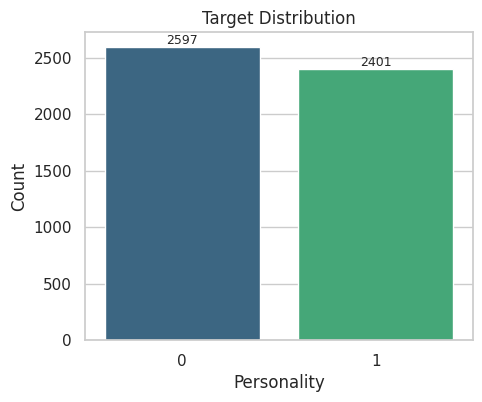

Class proportions:
Personality
0    0.519608
1    0.480392
Name: proportion, dtype: float64


In [31]:
# ---------- 1) Target Distribution ----------
plt.figure(figsize=(5,4))
ax = sns.countplot(x=TARGET, data=df, palette="viridis")
plt.title("Target Distribution")
plt.xlabel(TARGET)
plt.ylabel("Count")
for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}", (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.show()

print("Class proportions:")
print(df[TARGET].value_counts(normalize=True).rename("proportion"))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

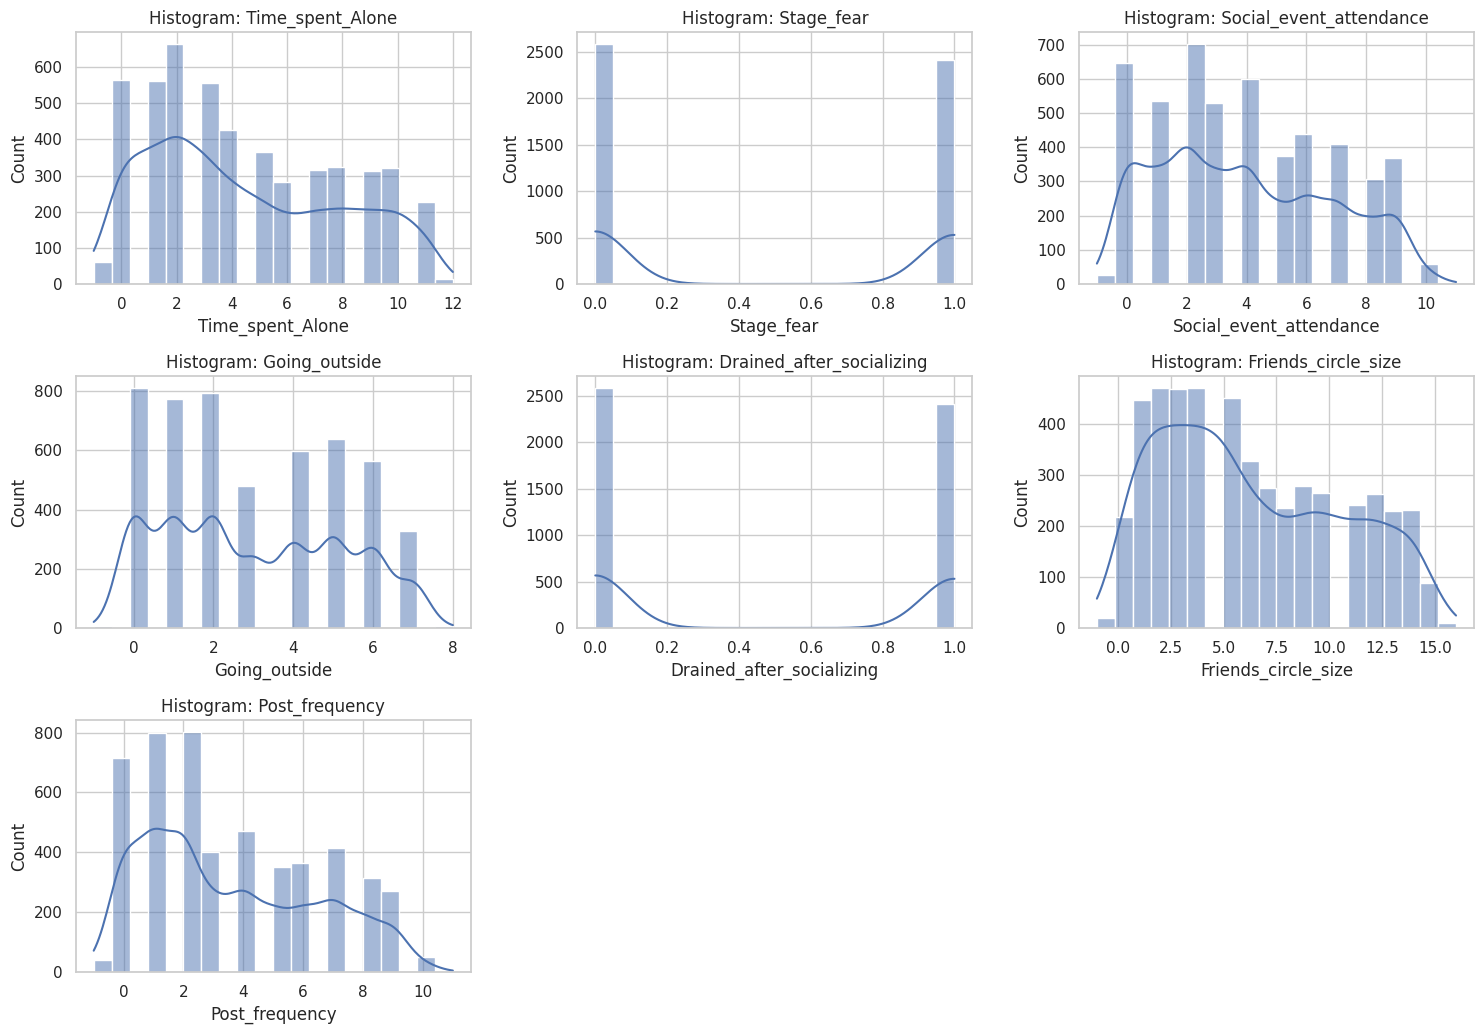

In [32]:
# ---------- 2) Histograms for numeric features ----------
n = len(num_cols)
cols = 3
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram: {col}")
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

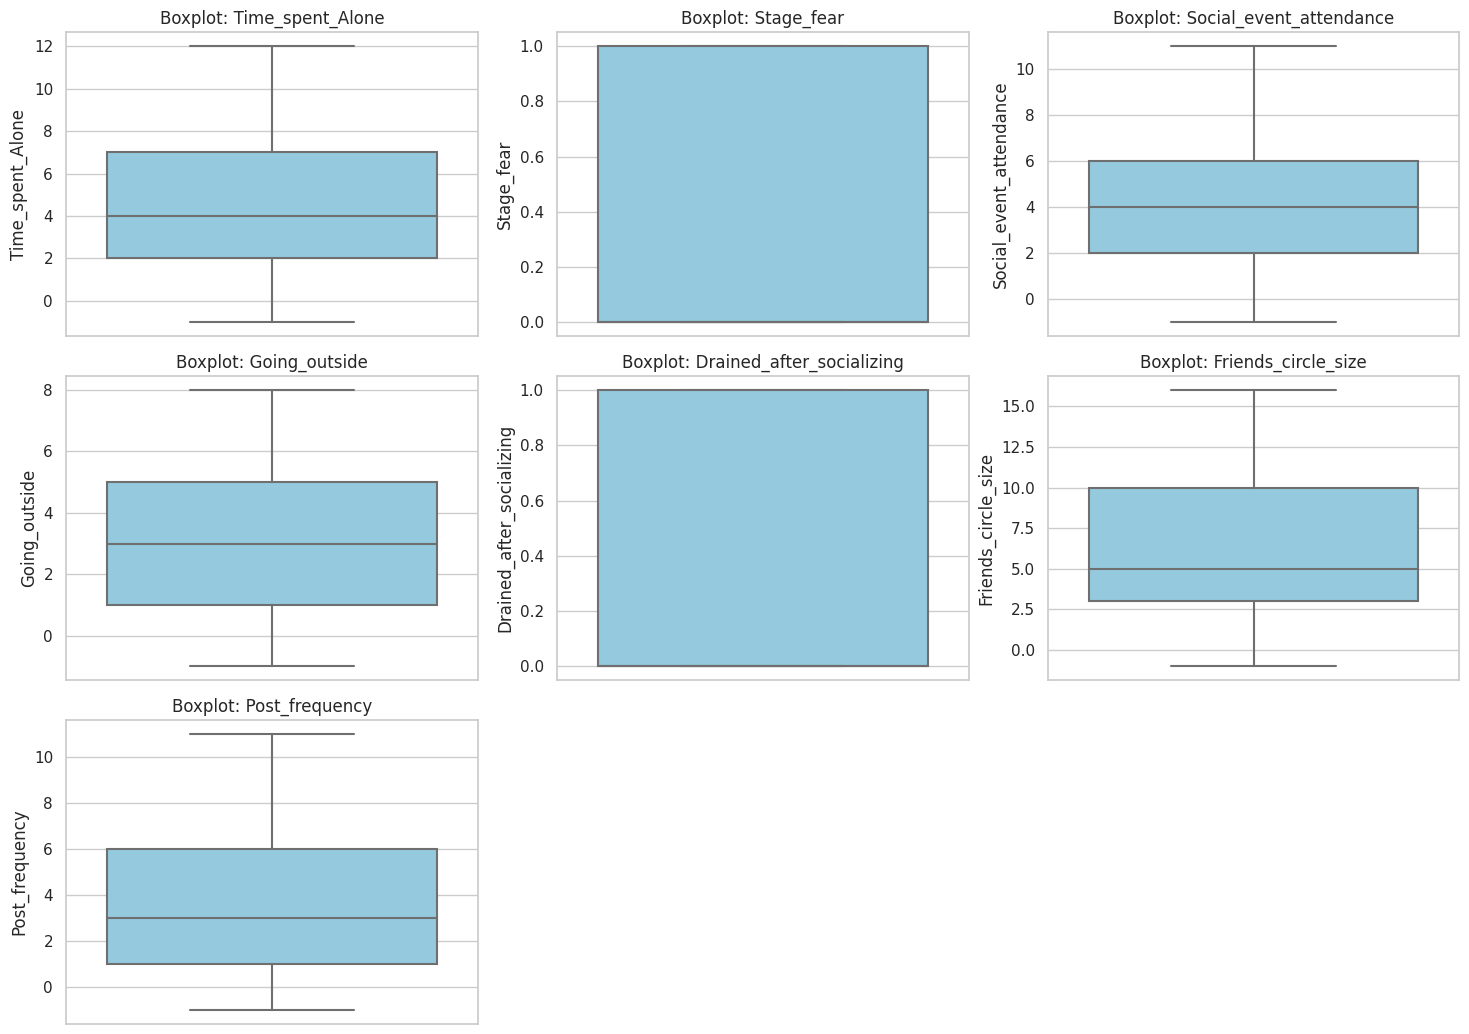

In [33]:
# ---------- 3) Boxplots (all numeric) ----------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="skyblue")
    axes[i].set_title(f"Boxplot: {col}")
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

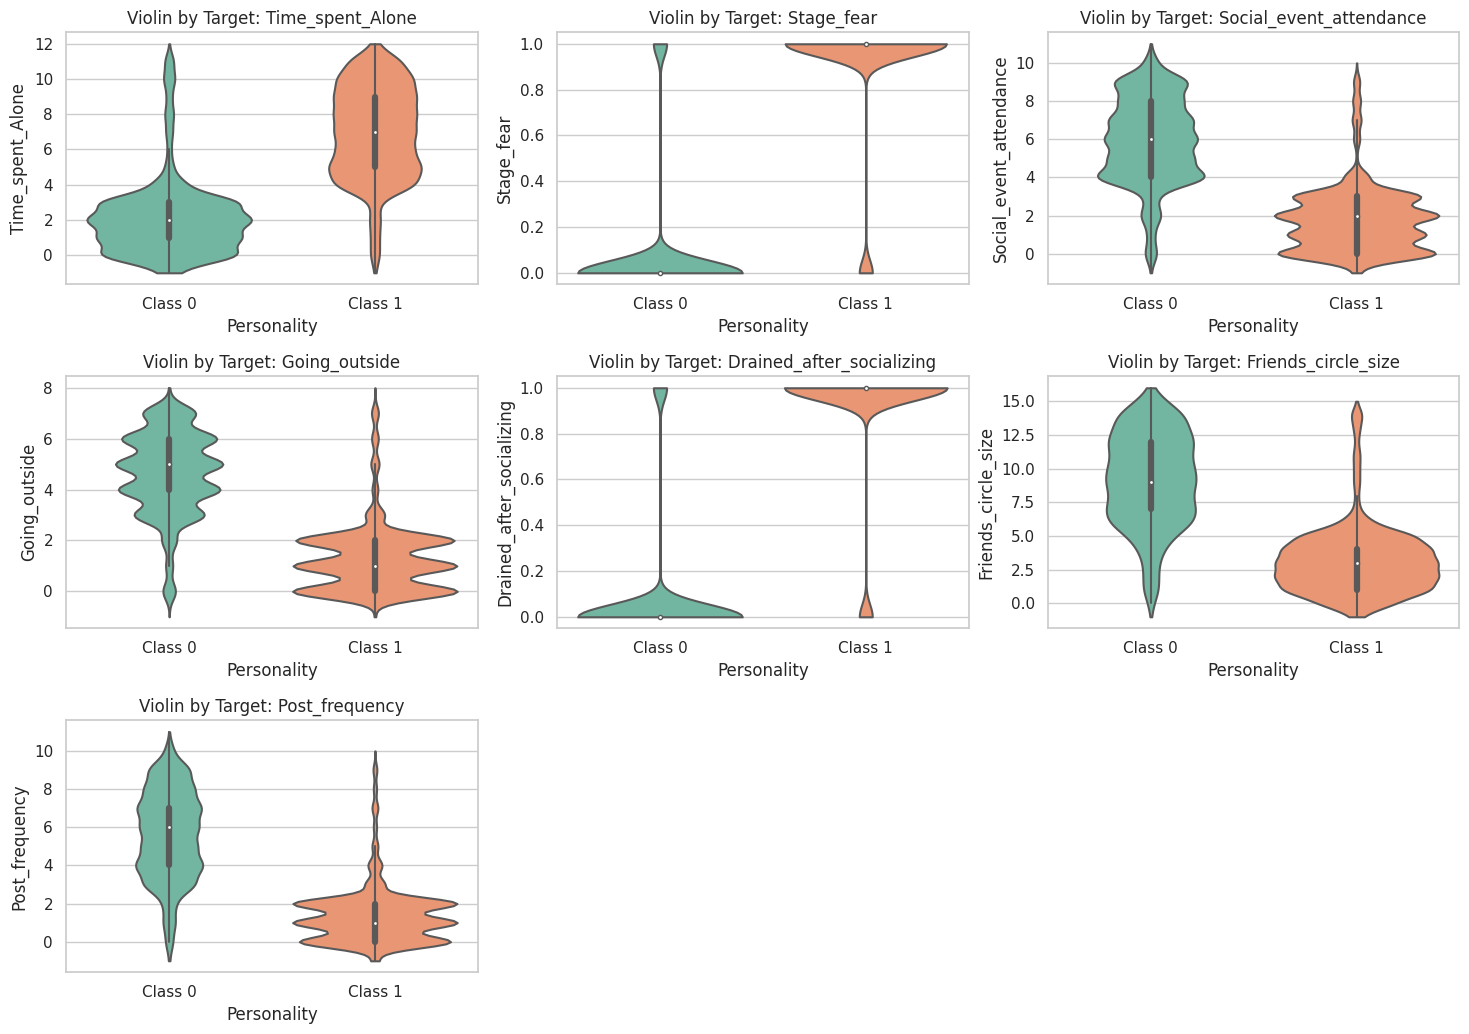

In [34]:
# ---------- 4) Violin plots by target ----------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.violinplot(x=df["_target_str"], y=df[col], ax=axes[i], palette="Set2", cut=0)
    axes[i].set_title(f"Violin by Target: {col}")
    axes[i].set_xlabel(TARGET)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


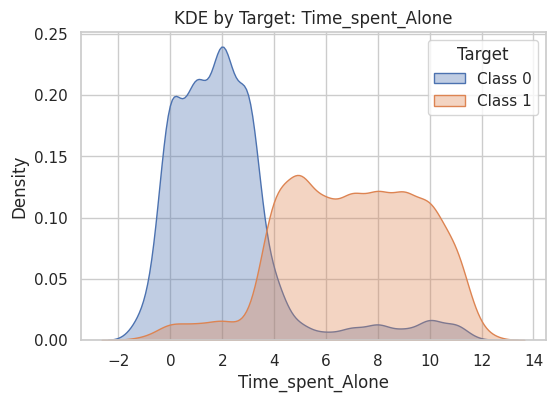

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


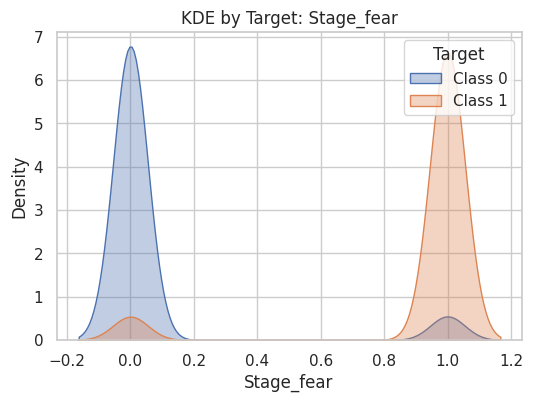

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


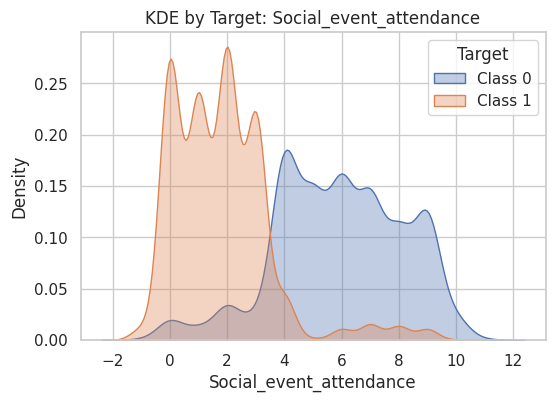

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


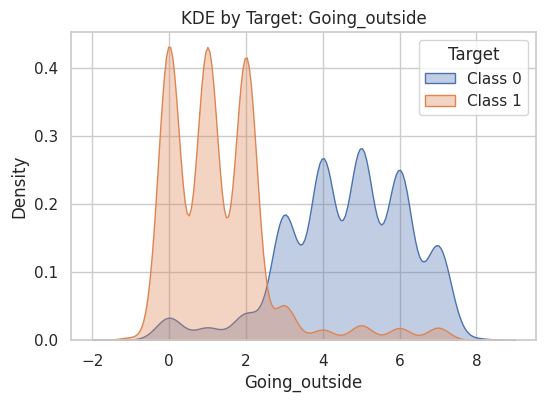

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


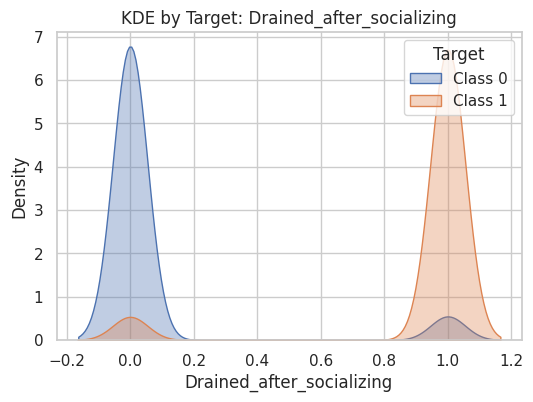

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


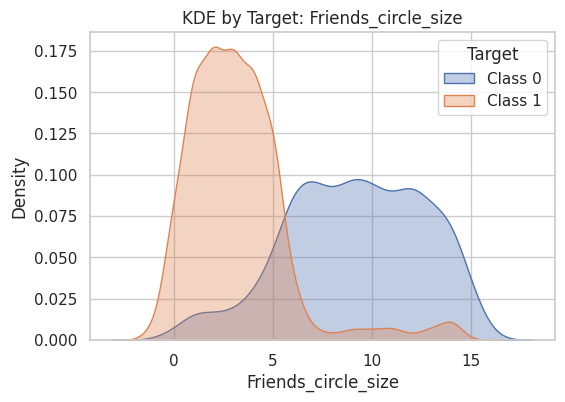

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


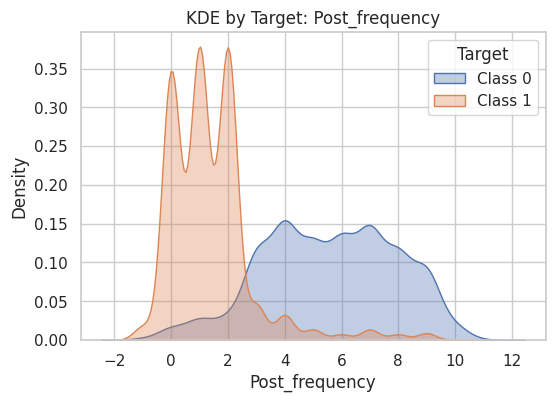

In [35]:
# ---------- 5) KDE overlays by target ----------
for col in num_cols:
    plt.figure(figsize=(6,4))
    for cls, df_part in df.groupby("_target_str"):
        sns.kdeplot(df_part[col], fill=True, alpha=0.35, label=cls)
    plt.title(f"KDE by Target: {col}")
    plt.xlabel(col); plt.ylabel("Density")
    plt.legend(title="Target")
    plt.show()

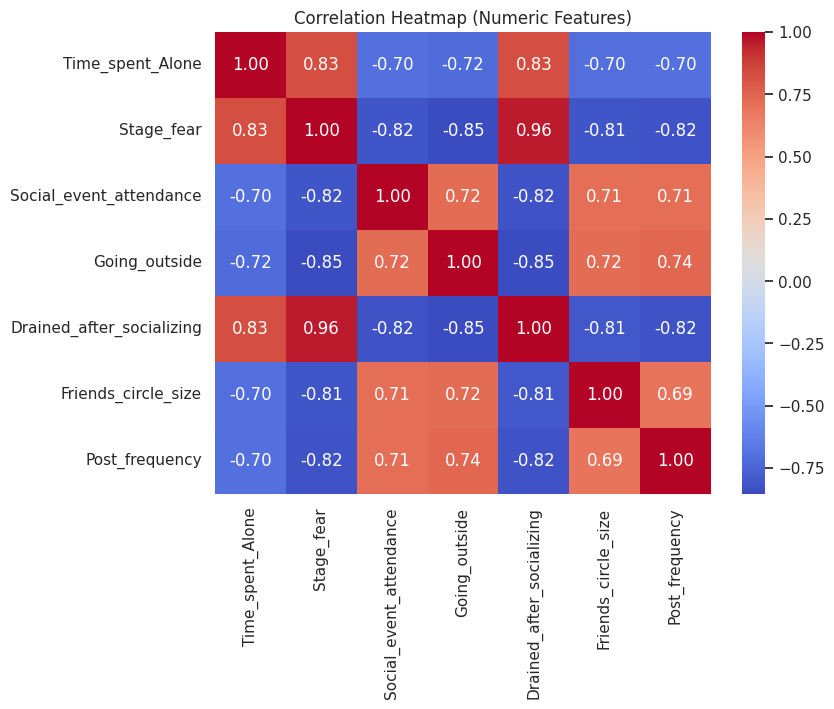

In [36]:
# ---------- 6) Correlation heatmap (numeric only) ----------
if len(num_cols) > 1:
    plt.figure(figsize=(8,6))
    corr = df[num_cols].corr(method="pearson")
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.show()


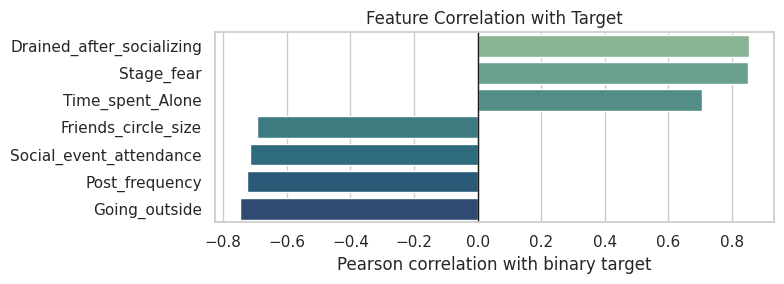

In [37]:
# ---------- 7) Correlation of each feature with target (point-biserial ~ Pearson with binary) ----------

y_bin = df[TARGET].astype(int)
corr_to_target = []
for col in num_cols:
    corr_to_target.append((col, np.corrcoef(df[col], y_bin)[0,1]))
corr_df = pd.DataFrame(corr_to_target, columns=["feature", "corr_with_target"]).sort_values("corr_with_target", ascending=False)

plt.figure(figsize=(8, max(3, 0.35*len(corr_df))))
sns.barplot(data=corr_df, x="corr_with_target", y="feature", palette="crest")
plt.axvline(0, color="k", lw=1)
plt.title("Feature Correlation with Target")
plt.xlabel("Pearson correlation with binary target")
plt.ylabel("")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

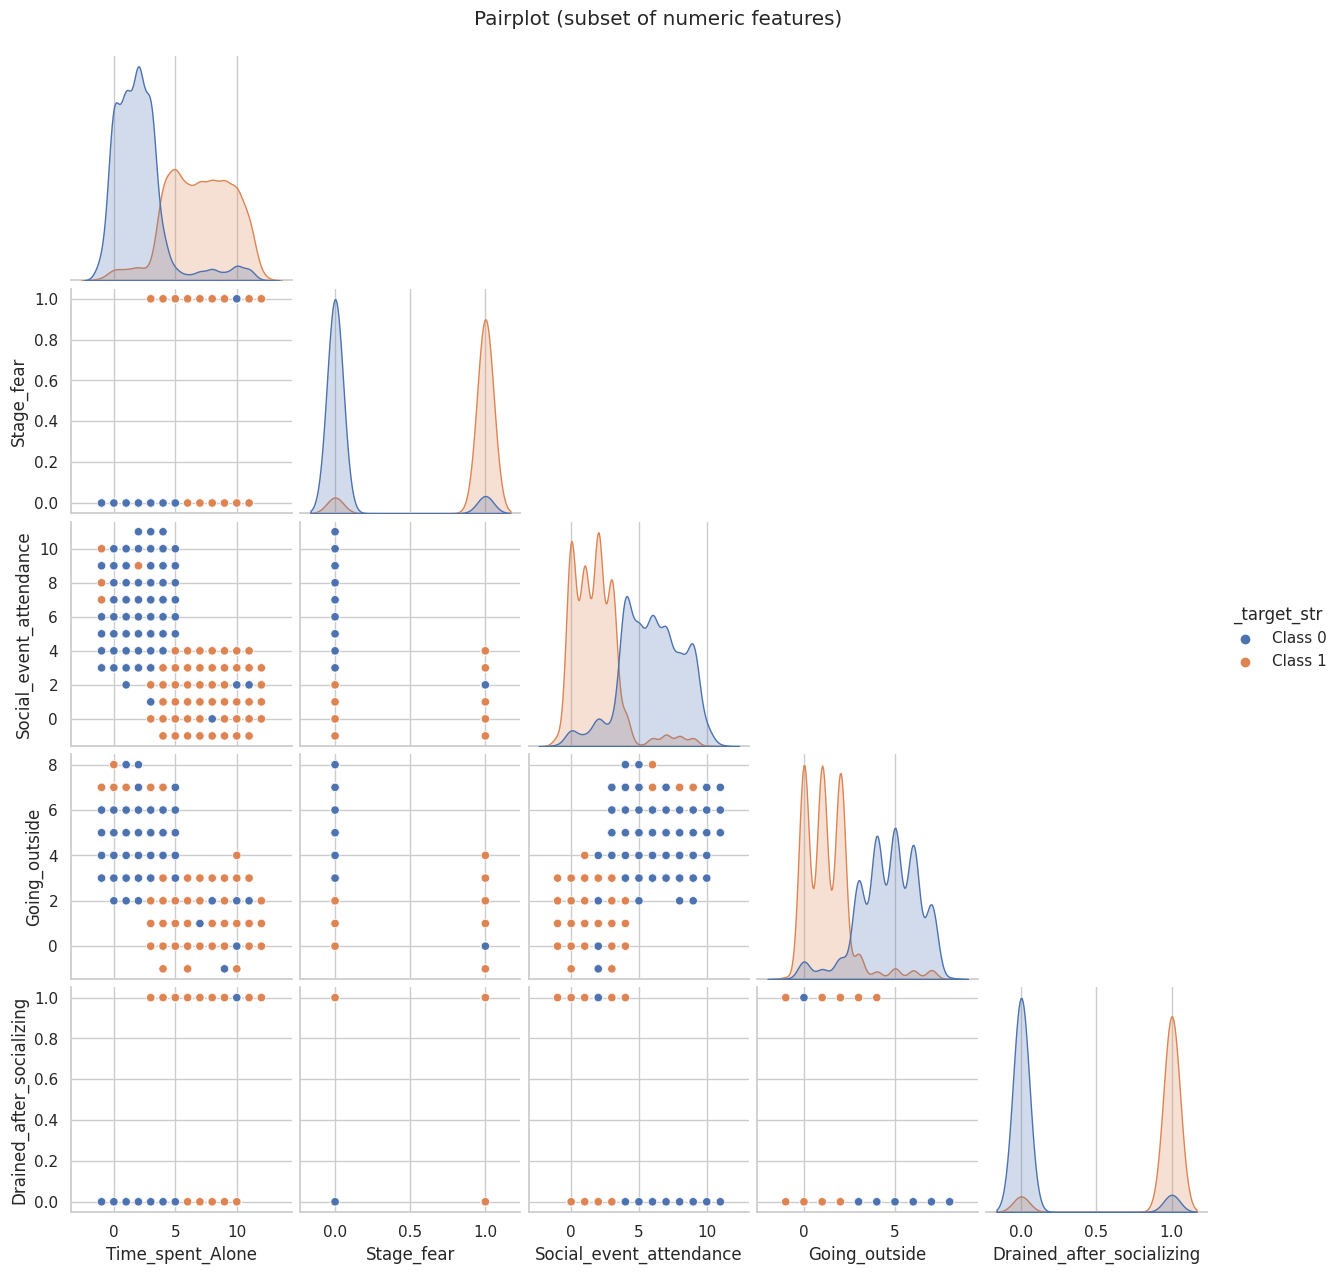

In [38]:
# ---------- 8) Pairplot (subset for readability) ----------
subset = num_cols[:5]  # take first 5 to keep it readable
if subset:
    sns.pairplot(df[subset + ["_target_str"]], hue="_target_str", corner=True, diag_kind="kde")
    plt.suptitle("Pairplot (subset of numeric features)", y=1.02)
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

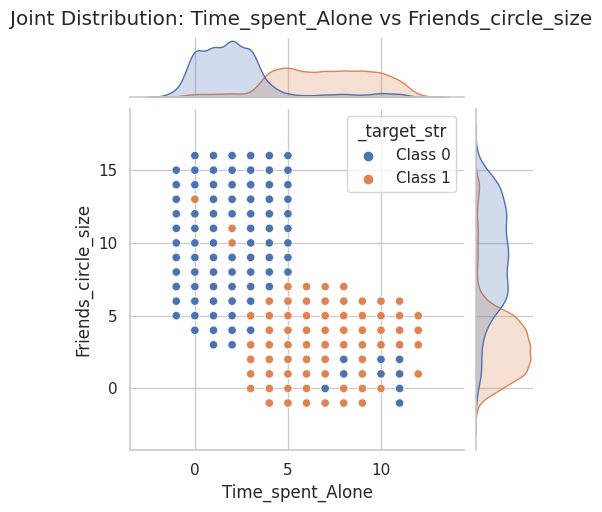

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

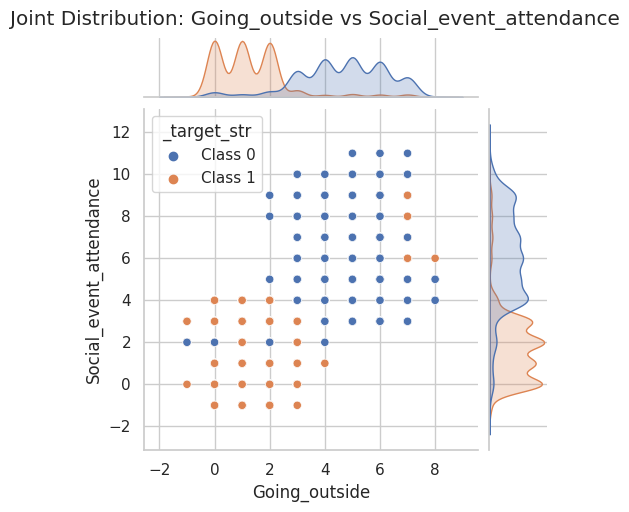

In [39]:
pairs = []
if "Time_spent_Alone" in df.columns and "Friends_circle_size" in df.columns:
    pairs.append(("Time_spent_Alone", "Friends_circle_size"))
if "Going_outside" in df.columns and "Social_event_attendance" in df.columns:
    pairs.append(("Going_outside", "Social_event_attendance"))

for x, y in pairs[:2]:  # limit to 2 pairs
    g = sns.jointplot(data=df, x=x, y=y, kind="scatter", hue="_target_str", height=5)
    plt.suptitle(f"Joint Distribution: {x} vs {y}", y=1.02)
    plt.show()

/tmp/ipykernel_36/1007966493.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x=df["_target_str"], y=df[col], ax=axes[i], alpha=0.6, jitter=0.25, palette="Set1")
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  da

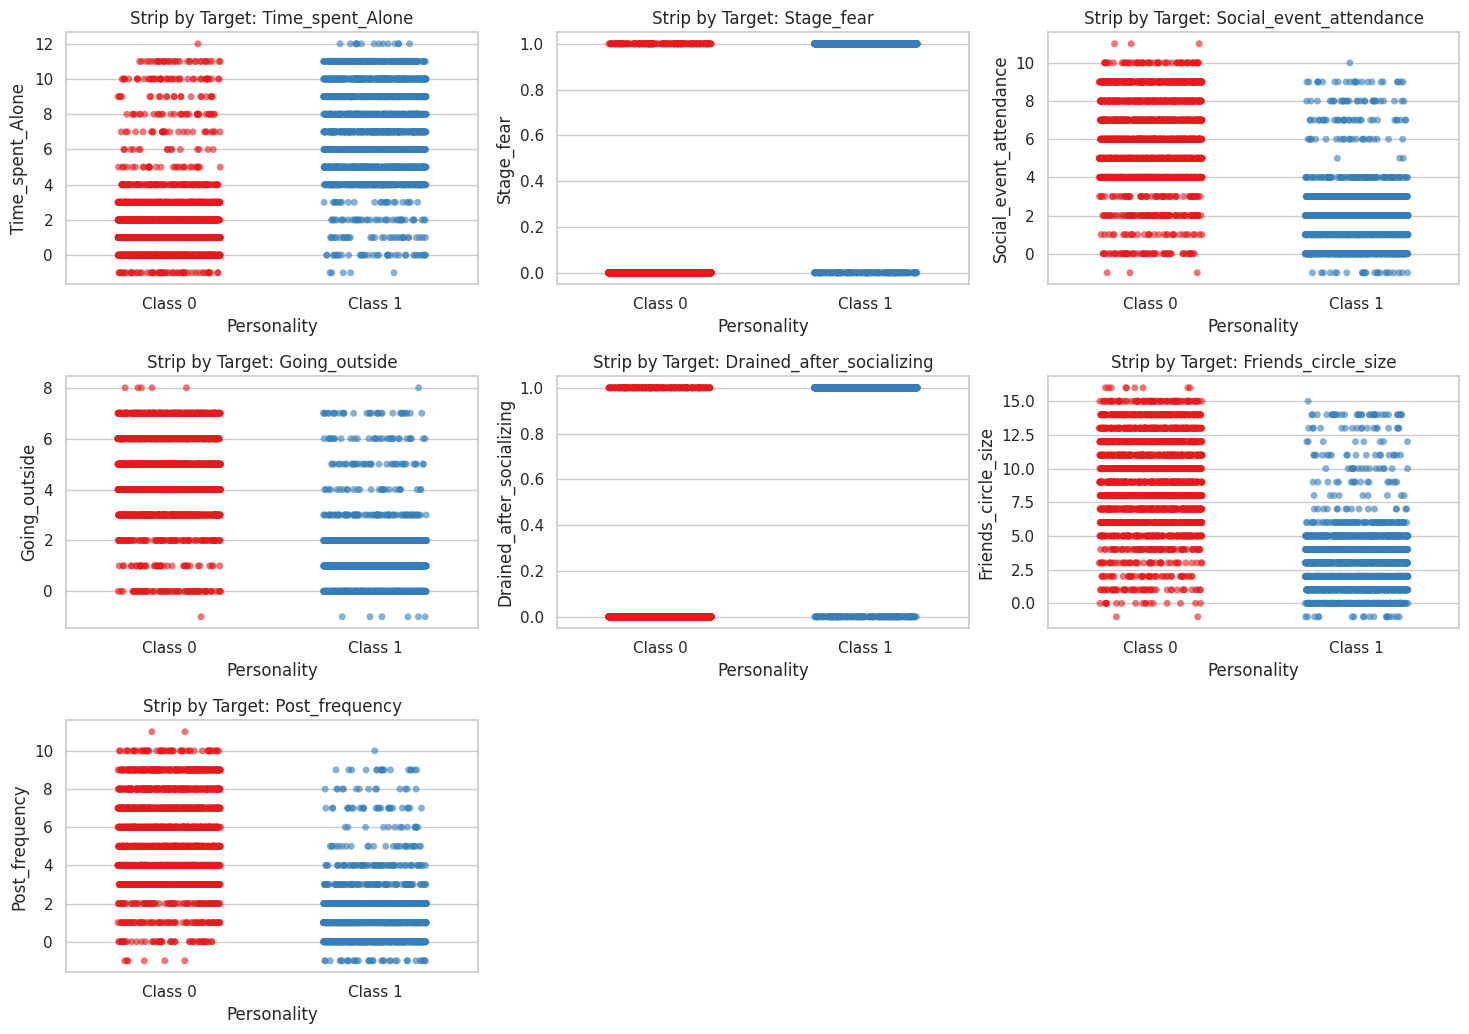

In [40]:
# ---------- 10) Strip/Swarm plots by target (distribution + jitter) ----------
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.5*rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    sns.stripplot(x=df["_target_str"], y=df[col], ax=axes[i], alpha=0.6, jitter=0.25, palette="Set1")
    axes[i].set_title(f"Strip by Target: {col}")
    axes[i].set_xlabel(TARGET)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [57]:


# 1. Load Dataset
df = pd.read_csv("/kaggle/input/personality-synthetic/Personality_Syncora_Synthetic 1(in).csv")

# 2. Separate features and target
# 👉 Replace 'personality' with your actual target column name
X = df.drop(columns=["Personality"])
y = df["Personality"]

# 3. Identify categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

# 4. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# 5. Build Pipeline with Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 7. Fit Model
gb_pipeline.fit(X_train, y_train)

# 8. Predictions
y_pred = gb_pipeline.predict(X_test)

# 9. Evaluation
print("=== Gradient Boosting Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 10. Cross-Validation for Robustness
cv_scores = cross_val_score(gb_pipeline, X, y, cv=5, scoring="f1_weighted")
print("\n5-Fold Cross-Validation F1 (weighted):")
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())


=== Gradient Boosting Results ===
Accuracy: 0.923
F1-score: 0.9230085587168835

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       520
           1       0.92      0.92      0.92       480

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000


5-Fold Cross-Validation F1 (weighted):
Mean: 0.9363908165577147 Std: 0.017032720076350996


In [59]:
# 1. Load Dataset
df = pd.read_csv("/kaggle/input/personality-synthetic/Personality_Syncora_Synthetic 1(in).csv")

In [60]:
X = df.drop(columns=["Personality"])
y = df["Personality"]

In [61]:
# 3. Identify categorical & numerical columns
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

In [62]:
# 4. Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [63]:
# 5. Build Pipeline with Gradient Boosting
gb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingClassifier(random_state=42))
])

In [64]:
# 6. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [65]:
# 7. Fit Model
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
       'Going_outside', 'Drained_after_socializing', 'Friends_circle_size',
       'Post_frequency'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index([], dtype='object'))])),
                ('model', GradientBoostingClassifier(random_state=42))])

In [66]:
# 8. Predictions
y_pred = gb_pipeline.predict(X_test)

In [67]:
# 9. Evaluation
print("=== Gradient Boosting Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred, average="weighted"))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

=== Gradient Boosting Results ===
Accuracy: 0.923
F1-score: 0.9230085587168835

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       520
           1       0.92      0.92      0.92       480

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



In [68]:
# 10. Cross-Validation for Robustness
cv_scores = cross_val_score(gb_pipeline, X, y, cv=5, scoring="f1_weighted")
print("\n5-Fold Cross-Validation F1 (weighted):")
print("Mean:", cv_scores.mean(), "Std:", cv_scores.std())


5-Fold Cross-Validation F1 (weighted):
Mean: 0.9363908165577147 Std: 0.017032720076350996
